In [1]:
import sys  
sys.path.insert(0, './Moduulit (.py)')

# Importtaus tässä muodossa
from database_connection import database_query
from outliers import find_outliers, draw_histogram
from clean_dataframe import clean_dataframe
from write_df_to_database import write_df_to_mariadb
from xy_diskretisointi import xy_to_grid

# tai from ... import *


# Jos datasetti on "df"

# Esim. find_outliers(df)
# Esim. draw_histogram(df['x'], df['y'], 20) <-- kolmas meinaa bins arvoa, eli histogrammin "rakeisuutta"

In [2]:
df = database_query("SELECT * FROM SensorData LIMIT 1000000;")
df.head(5)

,node_id,timestamp,x,y,z,q
0,b'-2393099149039893833',b'2020-06-24 12:20:08.533016+00:00',2762,-257,100,0
1,b'-2393099149039893833',b'2020-06-24 12:20:08.620015+00:00',2870,-344,100,0
2,b'-2393099149039893833',b'2020-06-24 12:20:09.622827+00:00',2916,-344,100,0
3,b'-2393099149039893833',b'2020-06-24 12:20:09.622846+00:00',2894,-254,100,0
4,b'-2393099149039893833',b'2020-06-24 12:20:10.116102+00:00',2888,-188,100,0


## Histogrammi datasta

x mean:  2007.42516
y mean:  524.458634
x std:  880.5673627763946
y std:  1056.1131432857248


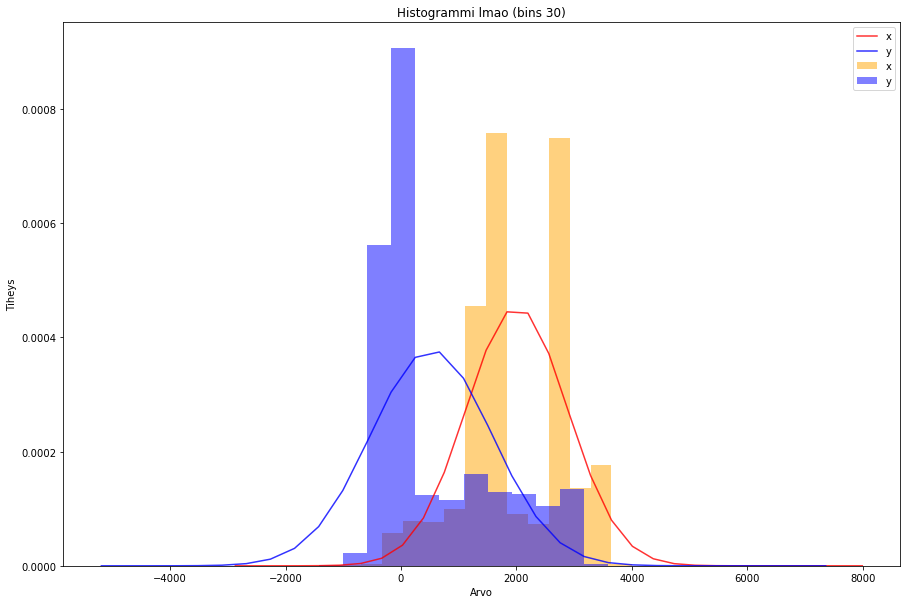

In [3]:
draw_histogram(df['x'], df['y'], 30)

## Etsitään outlierit

Number of missing variables in table
 node_id      0
timestamp    0
x            0
y            0
z            0
q            0
dtype: int64
------------------------------
Unique values in columns

uniques in x 5161
uniques in y 5033
uniques in z 1
uniques in q 1
------------------------------
Checking z and q columns

uniques in z [100]
uniques in q [0]
------------------------------
Number of nodes: 3
------------------------------
Outliers

Data with outliers:  1000000
Ouliers removed:     1567
Data without outliers:  998433


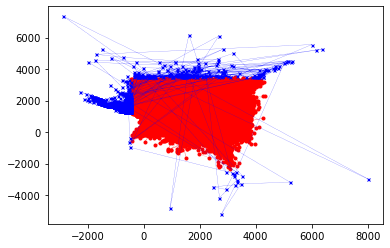

In [3]:
df1 = find_outliers(df)

In [4]:
df1

,node_id,timestamp,x,y,z,q
0,b'-2393099149039893833',b'2020-06-24 12:20:08.533016+00:00',2762,-257,100,0
1,b'-2393099149039893833',b'2020-06-24 12:20:08.620015+00:00',2870,-344,100,0
2,b'-2393099149039893833',b'2020-06-24 12:20:09.622827+00:00',2916,-344,100,0
3,b'-2393099149039893833',b'2020-06-24 12:20:09.622846+00:00',2894,-254,100,0
4,b'-2393099149039893833',b'2020-06-24 12:20:10.116102+00:00',2888,-188,100,0
...,...,...,...,...,...,...
999995,b'-2393099149039893848',b'2020-08-16 09:08:11.42598+00:00',1938,-267,100,0
999996,b'-2393099149039893848',b'2020-08-16 09:08:20.425996+00:00',1922,-242,100,0
999997,b'-2393099149039893848',b'2020-08-16 09:08:39.425912+00:00',2002,-332,100,0
999998,b'-2393099149039893848',b'2020-08-16 09:09:16.426101+00:00',1961,-281,100,0
